In [1]:
import os
import bye_cycle
import tensorflow as tf
# Disabling tf warnings
tf.get_logger().setLevel('INFO')
from tqdm import tqdm
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from beep.structure.cli import auto_load_processed
import random
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
input_window_size = 100
output_window_size = 100
pkl_f_l_filename = f'CACHED_DATA/pickled_cycle_windows/LFP/fearures_labels_inputs_window_{input_window_size}_outputs_window_{output_window_size}.pkl'
with open(pkl_f_l_filename, 'rb') as f:
    [cell_features, cell_labels] = pkl.load(f)  
print('Loaded Data.')

Loaded Data.


In [3]:
train_size=0.9
val_size=0.2
seed = 0
scaled_X_train_time_series, scaled_slopes_train, scaled_X_val_time_series, scaled_slopes_val, scaled_X_test_time_series, scaled_slopes_test, f_scaler, l_scaler = bye_cycle.process_data(cell_features, cell_labels, seed=seed, train_size=train_size, val_size=val_size)

prepared_data = list(zip(cell_features, cell_labels))
random.seed(0)
shuffled_indices = list(range(len(prepared_data)))
random.shuffle(prepared_data)

N_train = int(train_size *len(prepared_data))
N_val = int(val_size * N_train)
train_cells = prepared_data[:N_train]
test_cells = prepared_data[N_train:]

val_cells = train_cells[:N_val]
train_cells = train_cells[N_val:]

Train size:100
Validation size:25
Test size:14
Total cells: 139


In [4]:
model_file = f"CACHED_DATA/model_window_size_inputs_window_{input_window_size}_outputs_window_{output_window_size}"
json_file = open(model_file+'.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
model.load_weights(model_file+".h5")
print('Loaded model.')

Loaded model.


1/1 [==============================] - 0s 37ms/step


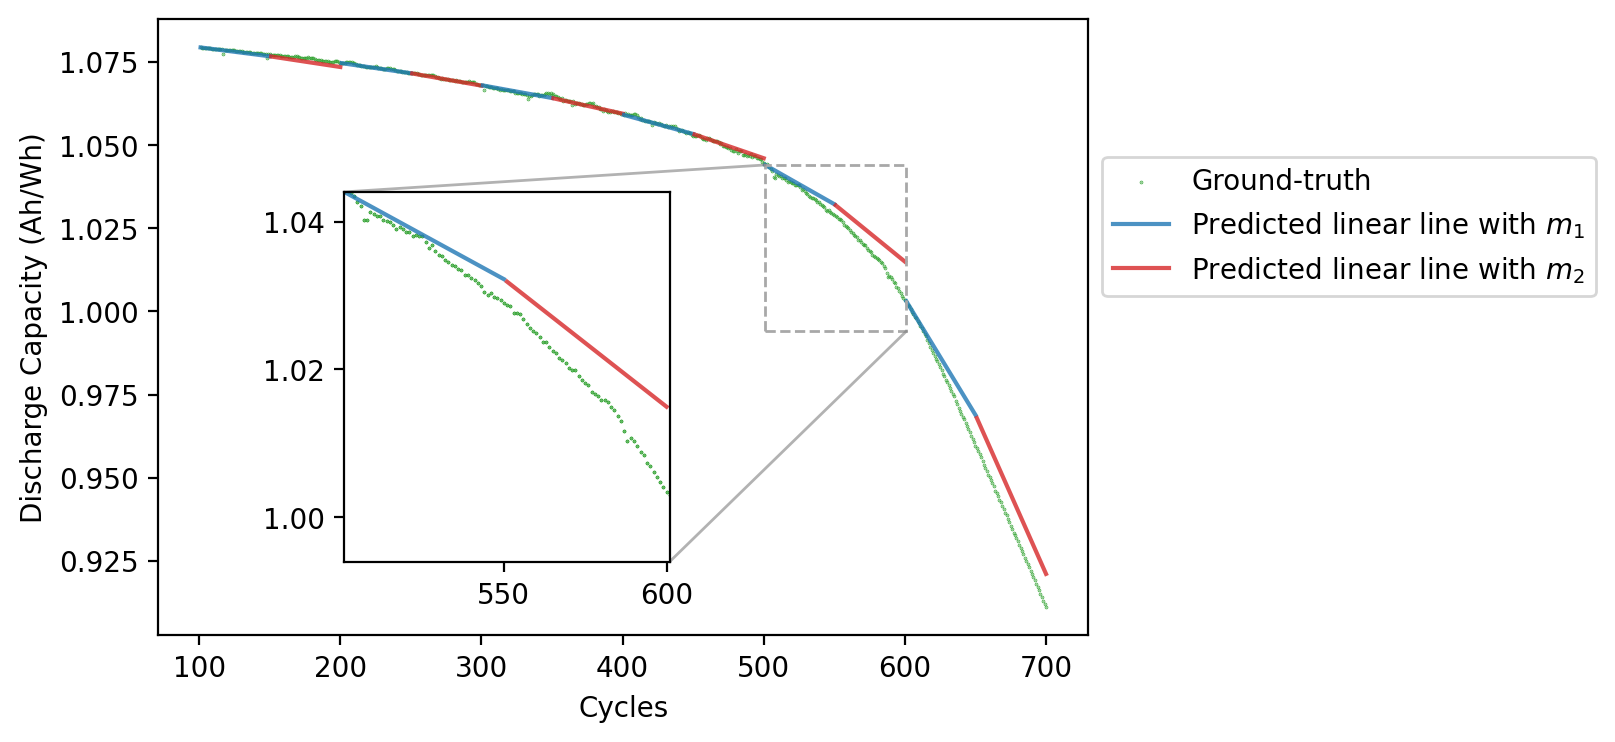

In [6]:
test_cell_number = 4
tested_cell = [test_cells[test_cell_number]]

X_tested_cell = [x for cycle in tested_cell for x in cycle[0]]
Y_tested_cell = [y for cycle in tested_cell for y in cycle[1]]
dc_tested_cell, slopes_tested_cell = bye_cycle.make_label_arrays(Y_tested_cell)
X_tested_cell_time_series, X_tested_cell_dt = bye_cycle.make_feature_arrays(X_tested_cell)

all_test_slopes = [y[0] for y in Y_tested_cell]
all_test_dc = np.array([y[1] for y in Y_tested_cell])

_, scaled_X_tested_cell_time_series = bye_cycle.scale(X_tested_cell_time_series[...,1:], f_scaler)
Y_hat_tested_cell = model.predict(scaled_X_tested_cell_time_series)
Y_hat_tested_cell = l_scaler.inverse_transform(Y_hat_tested_cell)

all_predicted_dc_values = []
max_cycle_index = all_test_dc.reshape([-1,2])[-1,0]
delta_slopes = []
RMSE_values = []
all_predicted_slopes = []
for i,m in enumerate(all_test_dc):
    if i == 0:
        plt.figure(dpi=200, facecolor='white', figsize=(6,4))
        plt.scatter(*list(zip(*all_test_dc.reshape([-1,2]))), color = 'C2', s=0.1, label='Ground-truth', alpha=0.8) #if i == 0 else "")

    initial_dc = m[0]
    initial_dc = m[0].tolist()

    predicted_dc_values = []

    new_cycle_index = m[0,0]
    slopes = []
    for j,slope in enumerate(Y_hat_tested_cell[i]):

        if j == 0 and output_window_size%2==0:
            new_cycle_index = all_test_dc[i][:output_window_size//2,0]
        if j == 0 and output_window_size%2==1:
            new_cycle_index = all_test_dc[i][:output_window_size//2+1,0]
        if j == 1:
            new_cycle_index = all_test_dc[i][output_window_size//2:,0]
        slopes.append(slope)

        new_predicted_dc = bye_cycle.linear_fit(new_cycle_index, slope, initial_dc) # slopes_tested_cell[i,j]
        predicted_dc = np.array(list(zip(new_cycle_index , new_predicted_dc)))

        predicted_dc_values.append(predicted_dc)
        if i==0 and j==0:
            label = r'Predicted linear line with $m_1$'
        elif  i==0 and j==1:
            label = r'Predicted linear line with $m_2$'
        else:
            label = ''
            
        plt.plot(new_cycle_index, new_predicted_dc, color='C0'if j%2==0 else 'C3', alpha=0.8, 
                 label=label)
        if i == 4:
            if j==0:
                xlim = new_cycle_index[0]
                ylim = new_predicted_dc[0]
                ax = plt.gca()
                inset_ax = ax.inset_axes([0.2, 0.12, 0.35, 0.6])
            inset_ax.plot(new_cycle_index, new_predicted_dc, alpha=0.8, color='C0'if j%2==0 else 'C3')
            inset_ax.scatter(*list(zip(*all_test_dc.reshape([-1,2]))), color = 'C2', s=0.1, label='Ground-truth', alpha=0.8) #if i == 0 else "")

            inset_ax.set_xlim([xlim, xlim+output_window_size])
            inset_ax.set_ylim([ylim-0.05, ylim])

        initial_dc = predicted_dc[-1]
    all_predicted_slopes.append(slopes)
    all_predicted_dc_values.append(np.array(predicted_dc_values).reshape(-1,2))
    predicted_dc_window = np.array(predicted_dc_values).reshape((-1,2))
    rmse = bye_cycle.eval_dc_reconstruction(predicted_dc_window, m)
    delta_slopes.append(np.abs(slopes[1]- slopes[0]))
    RMSE_values.append(rmse)
    
plt.xlabel('Cycles')
plt.ylabel('Discharge Capacity (Ah/Wh)')

inset_ax.locator_params(nbins=3)
alpha = 0.6
rect, lines = ax.indicate_inset_zoom(inset_ax, alpha=alpha)
rect.set_edgecolor('#a8a8a8')
rect.set_linestyle('--')
rect.set_alpha(alpha+0.4)
plt.legend(bbox_to_anchor=[1, 0.8])